# Multimodal deep learning
This notebook shows an example of training multi-modal, compounding multiple forms for data as input, deep learning with Keras.
Here, I compounded image, natural sound and explanation text, in Japanese.
Each datasets are imported from the following publicly open data.

- image: [Caltech256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/)
- natural sound: [ESC-50](https://github.com/karoldvl/ESC-50)
- text: [Wikipedia](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%82%A4%E3%83%B3%E3%83%9A%E3%83%BC%E3%82%B8)

## Rule

1. Use image, natural sound, text and numerics for input.
2. The model is in multimodal.
    - one for multiclass classification
    - one for regression
    - one for binary classification
3. Each row of data is a combination of image, sound, text and numerics in the same category.
    - The combination is generated randomly.
    - The dataset is divided into training and test.
4. One or two columns may be missing in some rows.
    - For instance, missing data may only contain image and sound, with text being None.
    - There may be some data with only one columns: e.g. only text.
    - Both training and test data may have some missing values.
5. The original dataset of images and sounds are downloaded and unzipped.
6. The wikipedia texts are copy-and-pasted manually.
7. The numerics are generated randomly.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd
from io import BytesIO
from PIL import Image
import cv2
import difflib
import re
import unicodedata
from keras import utils 

# define directories
base_dir = "./"

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


---

## Natural sound dataset from [ESC-50](https://github.com/karoldvl/ESC-50)

In [2]:
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

# load metadata
meta_data = pd.read_csv(meta_file)

# get data size
data_size = meta_data.shape
print(data_size)

# arrange target label and its name
esc_class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i,"target"] not in esc_class_dict.keys():
        esc_class_dict[meta_data.loc[i,"target"]] = meta_data.loc[i,"category"]

(2000, 7)


In [3]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

# example data
_x, _fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
_melsp = calculate_melsp(_x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(_x.shape, _melsp.shape, _fs))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


In [4]:
# dict of label to category of the sound dataset
print(esc_class_dict)

{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}


---

## Image dataset from [Caltech256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/)

In [5]:
oc256_dir = "./256_ObjectCategories"
oc256_dirs = [os.path.join(oc256_dir, x) for x in os.listdir(oc256_dir)]
oc256_files = [[os.path.join(x,y) for y in os.listdir(x)] for x in oc256_dirs]
oc_class_dict = {int(x.split("/")[-1].split(".")[0]): x.split("/")[-1].split(".")[1] for x in oc256_dirs}

In [6]:
def convert2dgray_to_3dgray(img_array):
    return np.array([[[y,y,y] for y in x] for x in img_array])

def resize_image_array(img_array, image_size=(299, 299)):
    if img_array is None:
        return None
    return cv2.resize(img_array, image_size)

In [7]:
# save image data in npz
def save_np_256_oc_data(x, data_type="train"):
    data_dir = "256_" + data_type
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    for _,c in enumerate(x):
        for _,f in enumerate(c):
            image_name = f.split("/")[3].split(".")[0]
            image_path = os.path.join(data_dir, image_name)
            if not os.path.exists(image_path):
                y = f.split("/")[2].split(".")[0]
                img = Image.open(os.path.join(f))
                img = np.asarray(img)
                if len(img.shape) == 2:
                    img = convert2dgray_to_3dgray(img)
                img = resize_image_array(img, image_size=(299, 299))
                np.savez(image_path, img=img, y=y)

# save_np_256_oc_data(oc256_files,  data_type="all")

In [8]:
# dict of label to category of the image dataset
print(oc_class_dict)

{111: 'house-fly', 187: 'skyscraper', 160: 'pez-dispenser', 228: 'triceratops', 42: 'coffin', 103: 'hibiscus', 115: 'ice-cream-cone', 90: 'gorilla', 233: 'tuning-fork', 145: 'motorbikes-101', 38: 'chimp', 236: 'unicorn', 246: 'wine-bottle', 230: 'trilobite-101', 16: 'boom-box', 150: 'octopus', 171: 'refrigerator', 2: 'american-flag', 214: 'teepee', 51: 'cowboy-hat', 159: 'people', 227: 'treadmill', 64: 'elephant-101', 123: 'ketch-101', 119: 'jesus-christ', 3: 'backpack', 180: 'screwdriver', 74: 'flashlight', 157: 'pci-card', 5: 'baseball-glove', 137: 'mars', 139: 'megaphone', 165: 'pram', 121: 'kangaroo-101', 178: 'school-bus', 229: 'tricycle', 58: 'doorknob', 53: 'desk-globe', 212: 'teapot', 158: 'penguin', 176: 'saddle', 213: 'teddy-bear', 177: 'saturn', 114: 'ibis-101', 219: 'theodolite', 107: 'hot-air-balloon', 191: 'sneaker', 102: 'helicopter-101', 4: 'baseball-bat', 144: 'minotaur', 172: 'revolver-101', 239: 'washing-machine', 216: 'tennis-ball', 25: 'cactus', 152: 'owl', 211: 't

## Generate combination of image and sound labels

In [9]:
# look for label that spells similar from the image and sound to make combinations
close_values = []
for ok,ov in oc_class_dict.items():
    for ek,ev in esc_class_dict.items():
        r = difflib.SequenceMatcher(None, ov, ev).ratio()
        if r > 0.6:
            close_values.append([ok,ov,ek,ev,r])
for l in close_values:
    print(l)

[228, 'triceratops', 13, 'crickets', 0.631578947368421]
[58, 'doorknob', 30, 'door_wood_knock', 0.6086956521739131]
[158, 'penguin', 44, 'engine', 0.7692307692307693]
[102, 'helicopter-101', 40, 'helicopter', 0.8333333333333334]
[239, 'washing-machine', 35, 'washing_machine', 0.9333333333333333]
[25, 'cactus', 5, 'cat', 0.6666666666666666]
[152, 'owl', 3, 'cow', 0.6666666666666666]
[245, 'windmill', 16, 'wind', 0.6666666666666666]
[142, 'microwave', 9, 'crow', 0.6153846153846154]
[113, 'hummingbird', 14, 'chirping_birds', 0.64]
[20, 'brain-101', 10, 'rain', 0.6153846153846154]
[7, 'bat', 5, 'cat', 0.6666666666666666]
[210, 'syringe', 28, 'snoring', 0.7142857142857143]
[170, 'rainbow', 45, 'train', 0.6666666666666666]
[170, 'rainbow', 10, 'rain', 0.7272727272727273]
[89, 'goose', 1, 'rooster', 0.6666666666666666]
[73, 'fireworks', 48, 'fireworks', 1.0]
[133, 'lightning', 26, 'laughing', 0.7058823529411765]
[251, 'airplanes-101', 47, 'airplane', 0.7619047619047619]
[56, 'dog', 0, 'dog', 

In [10]:
# These labels seem similar.
# Let's choose these labels as the dataset.
chosen_oc_esc = {
    58:30, #[58, 'doorknob', 30, 'door_wood_knock', 0.6086956521739131]
    102:40, #[102, 'helicopter-101', 40, 'helicopter', 0.8333333333333334]
    239:35, #[239, 'washing-machine', 35, 'washing_machine', 0.9333333333333333] 
    245:16, #[245, 'windmill', 16, 'wind', 0.6666666666666666]
    113:14, #[113, 'hummingbird', 14, 'chirping_birds', 0.64]
    170:10, #[170, 'rainbow', 10, 'rain', 0.7272727272727273]
    89:1, #[89, 'goose', 1, 'rooster', 0.6666666666666666]
    73:48, #[73, 'fireworks', 48, 'fireworks', 1.0]
    251:47, #[251, 'airplanes-101', 47, 'airplane', 0.7619047619047619]
    56:0, #[56, 'dog', 0, 'dog', 1.0]
    80:4 #[80, 'frog', 4, 'frog', 1.0]
}

In [11]:
# dict for Caltech image target label and category name
chosen_kv = {
    58:'door', 
    102:'helicopter',
    239:'washingmachine',
    245:'wind',
    113:'hummingbird',
    170:'rain',
    89:'chicken',
    73:'fireworks',
    251:'airplane',
    56:'dog',
    80:'frog'
}

In [12]:
# texts are downloaded from Wikipedia
textdir = "./wiki"
textfiles = [os.path.join(textdir, x) for x in os.listdir(textdir)]

In [13]:
# make a dict with key as label and value as a list of sentences
oc_txt_dict = {}
for t in textfiles:
    with open(t,'r', encoding='utf-8') as f:
        k = int(t.split("/")[-1].split("_")[0])
        d = f.readlines()
        d = [x.replace("\n","") for x in d]
        oc_txt_dict[k] = d

### Generate a set of training and test dataset

In [14]:
# Generate a compound of image, sound and text for each targets
esc_np_dir = "./ESC-50-master/audio/"
oc_np_dir = "./256_all"

texts_data_train = []
img_data_train = []
snd_data_train = []
target_train = []
target_b_train = []
category_train = []
num_data_train_0 = []
num_data_train_1 = []
num_data_train_2 = []

texts_data_test = []
img_data_test = []
snd_data_test = []
target_test = []
target_b_test = []
category_test = []
num_data_test_0 = []
num_data_test_1 = []
num_data_test_2 = []
t = 0

for ok,c in chosen_kv.items():
    oc_list = [os.path.join(oc_np_dir, x) for x in os.listdir(oc_np_dir) if int(x.split("_")[0])==ok]
    esc_list = [os.path.join(esc_np_dir, x) for x in os.listdir(esc_np_dir) if int(x.split("-")[-1].split(".")[0])==chosen_oc_esc[ok]]
    
    # choose test dataset
    test_text = random.sample(range(len(oc_txt_dict[ok])), 8) # list of test text index
    test_img = random.sample(range(len(oc_list)), 8) # list of test image index
    test_snd = random.sample(range(len(esc_list)), 8) # list of test sound index
    # make compound test data
    target_test.extend([t]*8)# list of training target
    target_b_test.extend([0 if t%2==0 else 1]*8)# list of training binary target
    texts_data_test.extend([v for i,v in enumerate(oc_txt_dict[ok]) if i in test_text])
    img_data_test.extend([v for i,v in enumerate(oc_list) if i in test_img])
    snd_data_test.extend([v for i,v in enumerate(esc_list) if i in test_snd])
    category_test.extend([c]*8)
    
    # make test data with one element missing
    missing = random.choices([0,1,2], k=8)
    for _,p in enumerate(missing):
        tt = [0] if p==0 else [oc_txt_dict[ok][random.choice(test_text)]]
        it = [None] if p==1 else [oc_list[random.choice(test_img)]]
        st = [None] if p==2 else [esc_list[random.choice(test_snd)]]
        texts_data_test.extend(tt)
        img_data_test.extend(it)
        snd_data_test.extend(st)
        target_test.extend([t])
        target_b_test.extend([0 if t%2==0 else 1])
        category_test.extend([c])
            
    # make test data with two elements missing
    have = random.choices([0,1,2], k=8)
    for _,p in enumerate(have):
        tt = [oc_txt_dict[ok][random.choice(test_text)]] if p==0 else [0]
        it = [oc_list[random.choice(test_img)]] if p==1 else [None]
        st = [esc_list[random.choice(test_snd)]] if p==2 else [None]
        texts_data_test.extend(tt)
        img_data_test.extend(it)
        snd_data_test.extend(st)
        target_test.extend([t])
        target_b_test.extend([0 if t%2==0 else 1])
        category_test.extend([c])
        
    # numerical test data
    nums = [t]*8*3
    nums = [_t+random.randint(-3,3) for _t in nums]
    num_data_test_0.extend(nums)
    nums = [t]*8*3
    nums = [_t+random.randint(-2,7) for _t in nums]
    num_data_test_1.extend(nums)
    nums = [t]*8*3
    nums = [_t+random.randint(-10,3) for _t in nums]
    num_data_test_2.extend(nums)
    
    # make compound dataset for training
    train_text = [v for i,v in enumerate(oc_txt_dict[ok]) if i not in test_text] # list of training text
    train_img = [v for i,v in enumerate(oc_list) if i not in test_img] # list of training img
    train_snd = [v for i,v in enumerate(esc_list) if i not in test_snd] # list of training sound
    # allowing some duplicates
    target_train.extend([t]*60)# list of training target
    target_b_train.extend([0 if t%2==0 else 1]*60)# list of training binary target
    texts_data_train.extend(random.choices(train_text, k=60))
    img_data_train.extend(random.choices(train_img, k=60))
    snd_data_train.extend(random.choices(train_snd, k=60))
    category_train.extend([c]*60)
    
    # make train data with one element missing
    missing = random.choices([0,1,2], k=60)
    for _,p in enumerate(missing):
        tt = [0] if p==0 else [random.choice(train_text)]
        it = [None] if p==1 else [random.choice(train_img)]
        st = [None] if p==2 else [random.choice(train_snd)]
        texts_data_train.extend(tt)
        img_data_train.extend(it)
        snd_data_train.extend(st)
        target_train.extend([t])
        target_b_train.extend([0 if t%2==0 else 1])
        category_train.extend([c])
        
    # make train data with two elements missing
    have = random.choices([0,1,2], k=60)
    for _,p in enumerate(have):
        tt = [random.choice(train_text)] if p==0 else [0]
        it = [random.choice(train_img)] if p==1 else [None]
        st = [random.choice(train_snd)] if p==2 else [None]
        texts_data_train.extend(tt)
        img_data_train.extend(it)
        snd_data_train.extend(st)
        target_train.extend([t])
        target_b_train.extend([0 if t%2==0 else 1])
        category_train.extend([c])
        
    # numerical test data
    nums = [t]*60*3
    nums = [_t+random.randint(-3,3) for _t in nums]
    num_data_train_0.extend(nums)
    nums = [t]*60*3
    nums = [_t+random.randint(-2,7) for _t in nums]
    num_data_train_1.extend(nums)
    nums = [t]*60*3
    nums = [_t+random.randint(-10,3) for _t in nums]
    num_data_train_2.extend(nums)
        
    t+=1

In [15]:
# make pandas dataframe for better looking
dataset_train = pd.DataFrame({
    "category":category_train,
    "target":target_train,
    "target_b":target_b_train,
    "data_0_img_path":img_data_train,
    "data_0_snd_path":snd_data_train,
    "data_0_txt":texts_data_train,
    "data_0_num" :num_data_train_0,
    "data_1_num" :num_data_train_1,
    "data_2_num" :num_data_train_2,
})
dataset_train.to_csv("./dataset_train.csv")
dataset_train

,category,target,target_b,data_0_img_path,data_0_snd_path,data_0_txt,data_0_num,data_1_num,data_2_num
0,door,0,0,./256_all/058_0054.npz,./ESC-50-master/audio/4-182041-A-30.wav,戸袋を持たないものも、機構的にはもちろん引き戸の一つといえる。,0,7,-1
1,door,0,0,./256_all/058_0006.npz,./ESC-50-master/audio/1-101336-A-30.wav,蝶番の発明以前（発明後でも伝来していない地域）においては、戸の一端に軸材（「とぼそ」「くるる...,1,7,2
2,door,0,0,./256_all/058_0039.npz,./ESC-50-master/audio/3-180147-A-30.wav,扉に取り付けた飼い犬や飼い猫などが通るための押し開き式の小さな扉は「ペットドア」という。,1,4,-5
3,door,0,0,./256_all/058_0090.npz,./ESC-50-master/audio/4-186518-A-30.wav,引き戸を開いたときの収納スペースを戸袋という。,-3,0,-6
4,door,0,0,./256_all/058_0026.npz,./ESC-50-master/audio/2-120218-B-30.wav,人や物の出入りを主目的しない建物の開口部は窓に分類する。,-2,3,-3
5,door,0,0,./256_all/058_0013.npz,./ESC-50-master/audio/4-182041-A-30.wav,炎熱を遮断して延焼を遅らせ、また煙を遮断することで避難者の安全を確保する。,-3,1,-1
6,door,0,0,./256_all/058_0093.npz,./ESC-50-master/audio/4-186518-A-30.wav,大径化や楕円形にすることで車いすの出入りに配慮したものや、引き戸と組み合わせて自動車など大型...,3,-2,-9
7,door,0,0,./256_all/058_0030.npz,./ESC-50-master/audio/3-154378-A-30.wav,大径化や楕円形にすることで車いすの出入りに配慮したものや、引き戸と組み合わせて自動車など大型...,3,-1,-6
8,door,0,0,./256_all/058_0040.npz,./ESC-50-master/audio/2-118624-A-30.wav,移動手段としてのバス（主に前扉に使われるが、近年のものは、路線バスを除き前扉に上記グライドス...,-3,2,-10
9,door,0,0,./256_all/058_0042.npz,./ESC-50-master/audio/4-261068-A-30.wav,片開き戸と両開き戸があり、突き上げて支えている戸が「突上戸（つきあげど）」、両開き戸は観音開...,1,7,-4


In [16]:
# make pandas dataframe for better looking
dataset_test = pd.DataFrame({
    "category":category_test,
    "target":target_test,
    "target_b":target_b_test,
    "data_0_img_path":img_data_test,
    "data_0_snd_path":snd_data_test,
    "data_0_txt":texts_data_test,
    "data_0_num" :num_data_test_0,
    "data_1_num" :num_data_test_1,
    "data_2_num" :num_data_test_2,
})
dataset_test.to_csv("./dataset_test.csv")
dataset_test

,category,target,target_b,data_0_img_path,data_0_snd_path,data_0_txt,data_0_num,data_1_num,data_2_num
0,door,0,0,./256_all/058_0038.npz,./ESC-50-master/audio/4-211502-A-30.wav,ドアという言葉も開き戸に対して使われ、通常は引き戸の事はドアとは言わない。,2,2,-6
1,door,0,0,./256_all/058_0067.npz,./ESC-50-master/audio/1-103999-A-30.wav,扉は建具のうちでも人や物の出入りに伴って頻繁に操作される部分であり、そのため開閉には多くの力...,0,3,2
2,door,0,0,./256_all/058_0059.npz,./ESC-50-master/audio/1-26188-A-30.wav,また、玄関扉は建物（集合住宅なら部屋）の内側から外側へ押す構造の開き戸が多い。,-1,7,-8
3,door,0,0,./256_all/058_0073.npz,./ESC-50-master/audio/5-250026-A-30.wav,自動扉（自動ドア）も引き戸である場合が多い。,1,0,-6
4,door,0,0,./256_all/058_0037.npz,./ESC-50-master/audio/3-151089-A-30.wav,扉の稼働部に人が立つと開かなかったり事故の原因になるため、立たないように色を変えたり注意喚起...,3,7,-8
5,door,0,0,./256_all/058_0002.npz,./ESC-50-master/audio/5-218981-A-30.wav,他のドアと同様、手動式と自動式がある。,0,2,-6
6,door,0,0,./256_all/058_0005.npz,./ESC-50-master/audio/4-182034-A-30.wav,日本では、2004年3月に六本木ヒルズ森タワーの自動回転扉で発生した事故以降に、ヒルズをはじ...,0,5,-1
7,door,0,0,./256_all/058_0086.npz,./ESC-50-master/audio/4-187284-A-30.wav,内側から開ける場合に、ロックを外す方法として、覆いを取ったり、割ったりする必要のある場合がある。,-2,5,-7
8,door,0,0,None,./ESC-50-master/audio/1-103999-A-30.wav,自動扉（自動ドア）も引き戸である場合が多い。,1,7,-10
9,door,0,0,./256_all/058_0067.npz,None,自動扉（自動ドア）も引き戸である場合が多い。,0,4,0


## Multi-modal deep learning in convolutional neural network

In [17]:
from multimodal_keras import multimodal_model, multimodal_iterator,base_models
from keras import (optimizers, losses)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [18]:
batch_size = 8
epochs = 1

## Multi-class classification

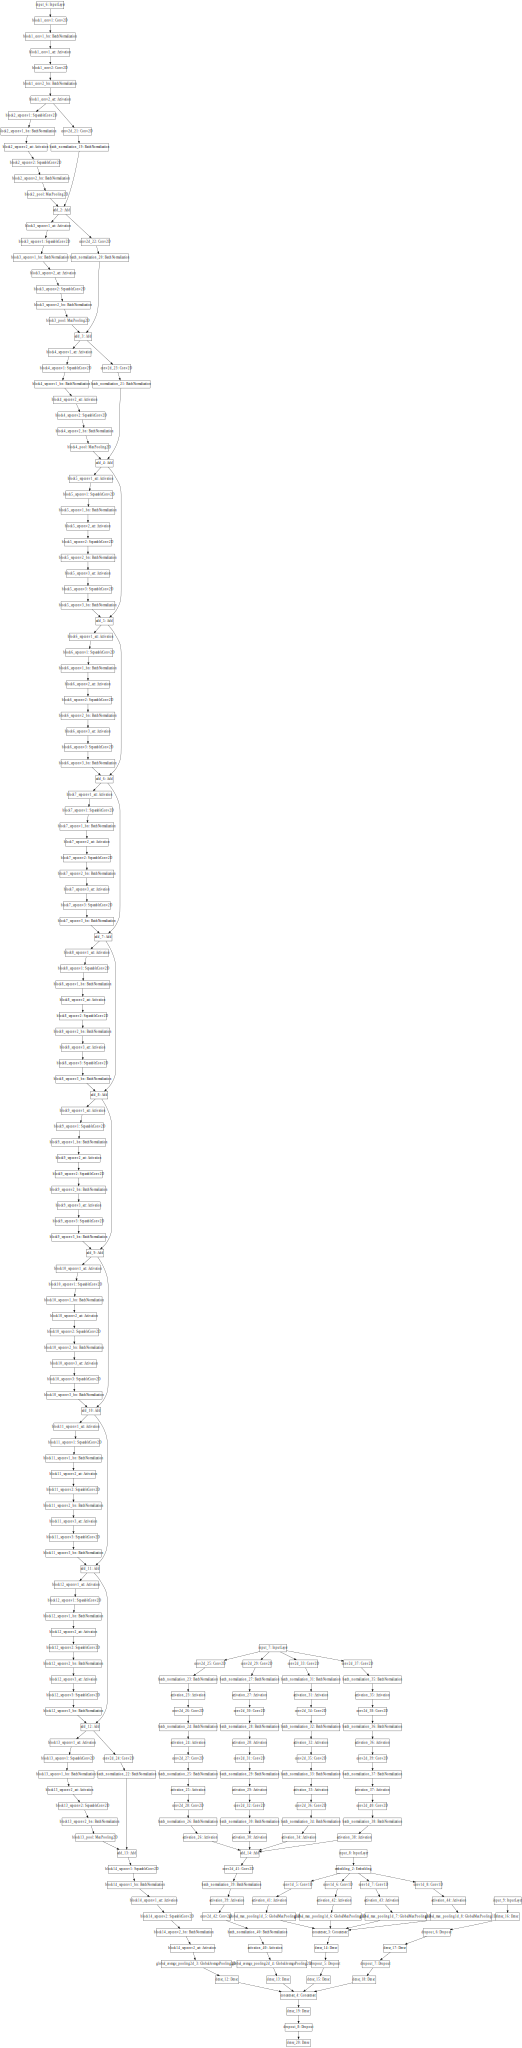

In [24]:
model = multimodal_model.MultiModalClassifier(
    inputs_df = dataset_train, 
    target_column="target")()
model.compile(
    optimizer=optimizers.Adam(lr=1e-4, decay=1e-6, amsgrad=True),
    loss=losses.categorical_crossentropy,
    metrics=['accuracy'])

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [25]:
training_generator = multimodal_iterator.MultiModalIterator(
    dataset_train,
    target_column="target",
    train=True,
    model_type="multiclassifier",
    batch_size=batch_size,
    shuffle=True)()

val_generator = multimodal_iterator.MultiModalIterator(
    dataset_test,
    target_column="target",
    train=False,
    model_type="multiclassifier",
    batch_size=batch_size,
    shuffle=False)()

In [26]:
# train
model.fit_generator(
        training_generator,
        steps_per_epoch=len(dataset_train)//batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=len(dataset_test)//batch_size,
        workers=6,
        use_multiprocessing=True)

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
247/247 [==============================] - 163s 660ms/step - loss: 1.3354 - acc: 0.5800 - val_loss: 0.5058 - val_acc: 0.8409


## Regression

In [27]:
from keras.layers import Dense, Dropout
def numerical_mlp_small(inputs, output_size):
    x = Dense(128, activation="relu")(inputs)
    x = Dropout(0.2)(x)
    x = Dense(output_size)(x)
    return x

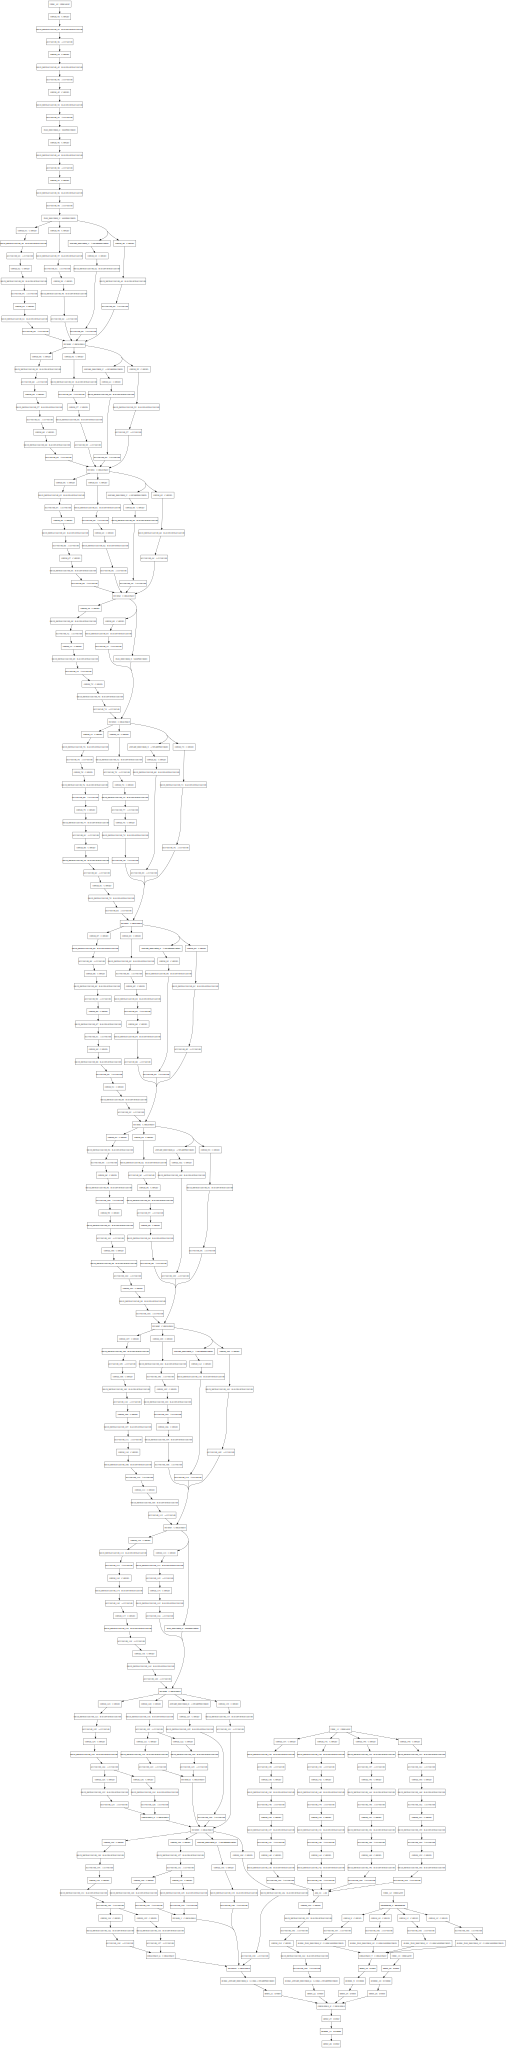

In [28]:
model = multimodal_model.MultiModalRegressor(
    inputs_df = dataset_train, 
    target_column="target",
    img_feature_extraction=base_models.image_inception_v3,
    num_mlp=numerical_mlp_small)()
model.compile(
    optimizer=optimizers.Adam(lr=1e-4, decay=1e-6, amsgrad=True),
    loss=losses.mean_squared_error)

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [29]:
training_generator = multimodal_iterator.MultiModalIterator(
    dataset_train,
    target_column="target",
    train=True,
    model_type="regressor",
    batch_size=batch_size,
    shuffle=True)()

val_generator = multimodal_iterator.MultiModalIterator(
    dataset_test,
    target_column="target",
    train=False,
    model_type="regressor",
    batch_size=batch_size,
    shuffle=False)()

In [30]:
# train
model.fit_generator(
        training_generator,
        steps_per_epoch=len(dataset_train)//batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=len(dataset_test)//batch_size,
        workers=6,
        use_multiprocessing=True)

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
247/247 [==============================] - 172s 695ms/step - loss: 3.1233 - val_loss: 1.5044


## Binary classification

In [19]:
import keras
from keras import Input
from keras.layers import (Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D)

img_input = Input(shape=(299,299,3))
def image_cnn(inputs, output_size):
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(output_size, activation="relu")(x)
    return x
img_x = image_cnn(img_input, 256)

num_input = Input(shape=(1,))
def num_1_mlp(inputs, output_size):
    x = Dense(16)(inputs)
    x = Dense(output_size)(x)
    return x
num_x = num_1_mlp(num_input, 256)
    
modal_layer_dict = {
    "data_0_img_path":{"inputs":img_input, "feature_extraction":img_x, "format":"img_path"},
    "data_1_num":{"inputs":num_input, "feature_extraction":num_x, "format":"num"}
                   }

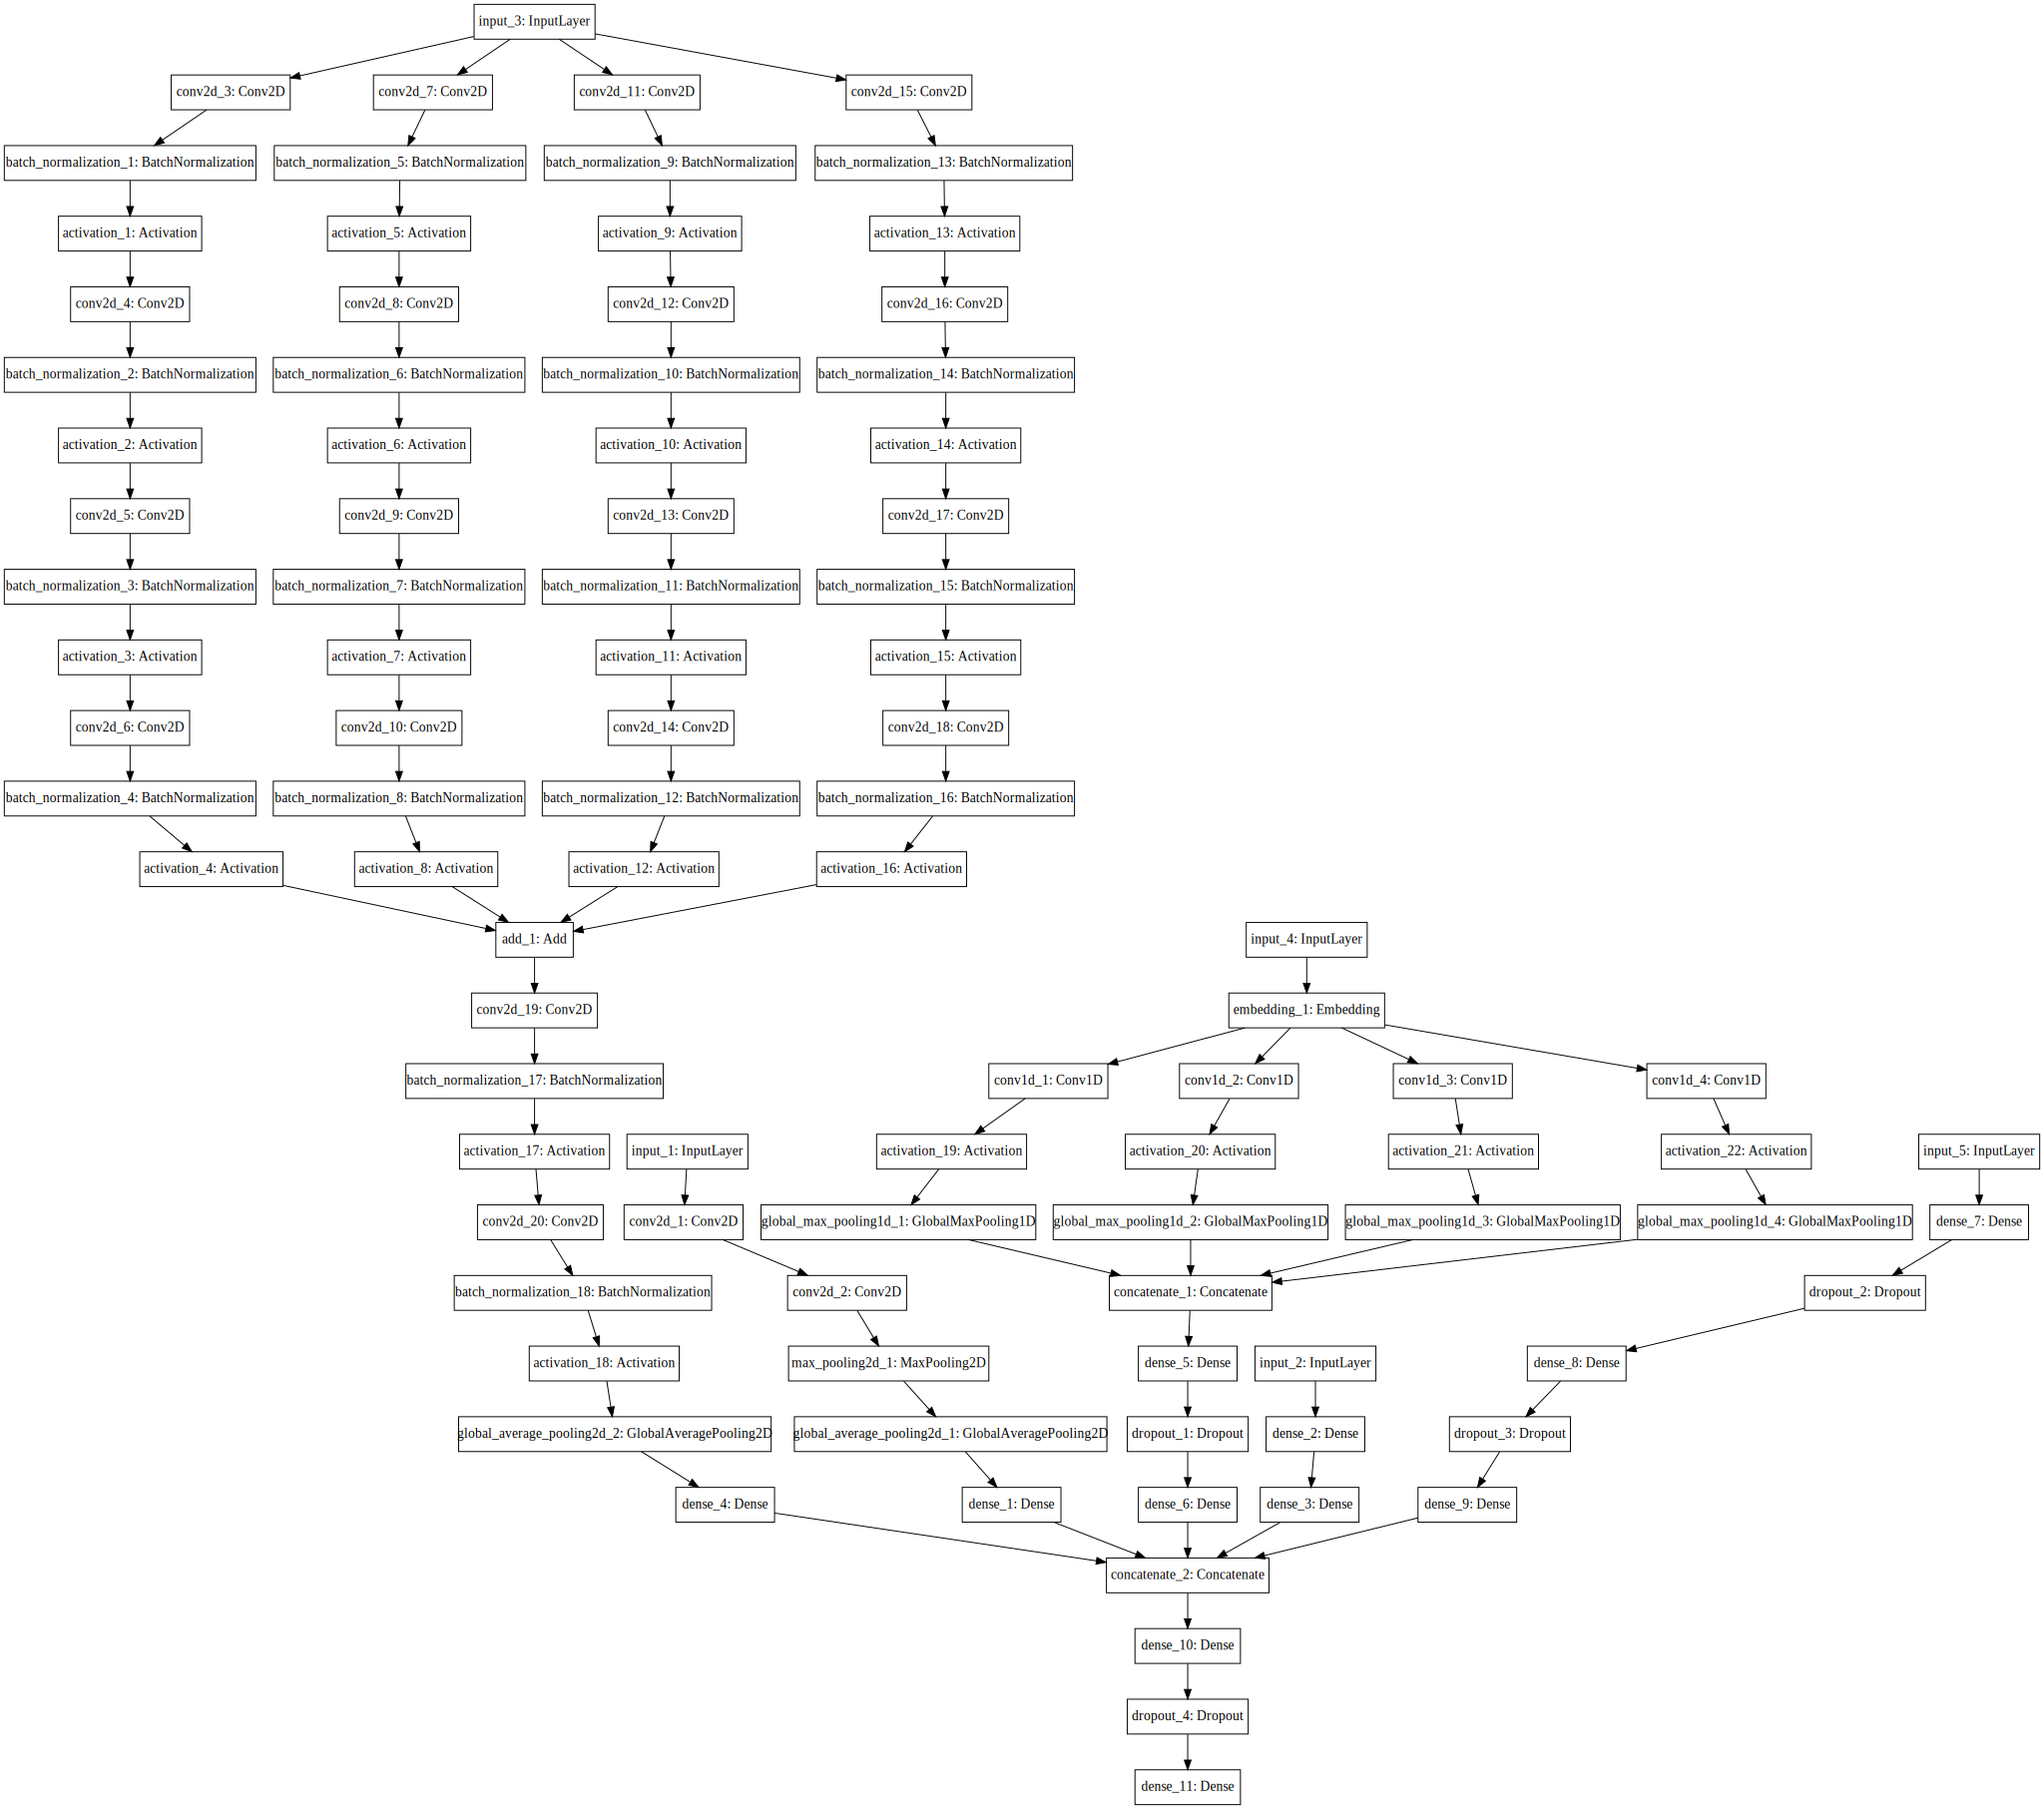

In [20]:
mbc = multimodal_model.MultiModalBinaryClassifier(
    inputs_df = dataset_train, 
    target_column="target_b",
    modal_layer_dict=modal_layer_dict)
model = mbc()
model.compile(optimizer=optimizers.Adam(lr=1e-4, decay=1e-6, amsgrad=True),
             loss=losses.binary_crossentropy,
             metrics=['accuracy'])

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [22]:
training_generator = multimodal_iterator.MultiModalModelIterator(
    multimodalmodel=mbc,
    data_df=dataset_train,
    target_column="target_b",
    train=True,
    batch_size=batch_size,
    shuffle=True)()

val_generator = multimodal_iterator.MultiModalModelIterator(
    multimodalmodel=mbc,
    data_df=dataset_test,
    target_column="target_b",
    train=False,
    batch_size=batch_size,
    shuffle=False)()

In [23]:
# train
model.fit_generator(
        training_generator,
        steps_per_epoch=len(dataset_train)//batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=len(dataset_test)//batch_size,
        workers=6,
        use_multiprocessing=True)

Epoch 1/1


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


247/247 [==============================] - 144s 582ms/step - loss: 9.2298 - acc: 0.4211 - val_loss: 8.6958 - val_acc: 0.4545
